<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

## Loading of Stringer spontaneous data



In [4]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [5]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [6]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [7]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [8]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [9]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [10]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1])

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [11]:
#unshuffled = np.array(data_)

In [12]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [13]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [14]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
    normed_dataRNN.append(neuron / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 

avgd_normed_dataRNN = moving_avg(normed_dataRNN, factor=5)

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [164]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

# let's use 270 latent components
ncomp = int(1131/2)
ncomp1 = int(ncomp/2)

In [161]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 1404)

In [163]:
frac = 5/6
#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

#x1_train = torch.from_numpy(avgd_normed_dataRNN[:1131,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
#x2_train = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

NN1 = x1.shape[0]
NN2 = x2.shape[0]

In [178]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()

        self.ncomp = ncomp
        # play with some of the options in the RNN!
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        
        self.rnn2 = nn.RNN(ncomp, ncomp1, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        """
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        self.fc = nn.Linear(ncomp1, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y1, h_n1 = self.rnn(x)
        print(y1.shape)
        y, h_n = self.rnn2(y1, h_n1)

        # print(y.shape)
        # print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y


        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        # print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [179]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean(axis = (0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer1 = torch.optim.Adam(net.parameters(), lr=.0001)
# optimizer2 = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.01, )
# optimizer3 = torch.optim.

In [180]:
# forward check 
net(x1)

torch.Size([1404, 1, 1131])
torch.Size([1404, 1, 1130])


RuntimeError: input.size(-1) must be equal to input_size. Expected 565, got 1130

## Training 

In [157]:
from tqdm import tqdm

In [158]:
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 5000 
#niter = 5000
#RNN_loss = 0.2173: LSTM_loss = 0.2144 ; GRU_loss = 0.2170
for k in tqdm(range(niter)):
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1)

    # our cost
    loss = cost(z, x2)

    # train the network as usual
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()

    if k % 50 == 0:
        print(f' iteration {k}, cost {loss.item():.4f}')


  0%|          | 6/5000 [00:00<03:09, 26.33it/s]

 iteration 0, cost 0.5634



  1%|          | 54/5000 [00:01<02:54, 28.30it/s]

 iteration 50, cost 0.4741



  2%|▏         | 105/5000 [00:03<02:47, 29.14it/s]

 iteration 100, cost 0.4713



  3%|▎         | 154/5000 [00:05<02:46, 29.15it/s]

 iteration 150, cost 0.4659



  4%|▍         | 205/5000 [00:07<02:45, 29.00it/s]

 iteration 200, cost 0.4546



  5%|▌         | 256/5000 [00:08<02:48, 28.20it/s]

 iteration 250, cost 0.4395



  6%|▌         | 304/5000 [00:10<02:43, 28.74it/s]

 iteration 300, cost 0.4241



  7%|▋         | 355/5000 [00:12<02:42, 28.66it/s]

 iteration 350, cost 0.4105



  8%|▊         | 406/5000 [00:14<02:41, 28.50it/s]

 iteration 400, cost 0.3985



  9%|▉         | 455/5000 [00:15<02:37, 28.85it/s]

 iteration 450, cost 0.3876



 10%|█         | 504/5000 [00:17<02:36, 28.70it/s]

 iteration 500, cost 0.3777



 11%|█         | 556/5000 [00:19<02:33, 28.86it/s]

 iteration 550, cost 0.3687



 12%|█▏        | 604/5000 [00:21<02:34, 28.54it/s]

 iteration 600, cost 0.3602



 13%|█▎        | 655/5000 [00:22<02:31, 28.61it/s]

 iteration 650, cost 0.3522



 14%|█▍        | 706/5000 [00:24<02:31, 28.31it/s]

 iteration 700, cost 0.3447



 15%|█▌        | 754/5000 [00:26<02:25, 29.11it/s]

 iteration 750, cost 0.3377



 16%|█▌        | 805/5000 [00:28<02:23, 29.18it/s]

 iteration 800, cost 0.3310



 17%|█▋        | 856/5000 [00:29<02:23, 28.83it/s]

 iteration 850, cost 0.3248



 18%|█▊        | 904/5000 [00:31<02:20, 29.12it/s]

 iteration 900, cost 0.3188



 19%|█▉        | 955/5000 [00:33<02:19, 29.02it/s]

 iteration 950, cost 0.3133



 20%|██        | 1006/5000 [00:35<02:16, 29.16it/s]

 iteration 1000, cost 0.3081



 21%|██        | 1054/5000 [00:36<02:18, 28.50it/s]

 iteration 1050, cost 0.3031



 22%|██▏       | 1105/5000 [00:38<02:15, 28.71it/s]

 iteration 1100, cost 0.2986



 23%|██▎       | 1156/5000 [00:40<02:14, 28.66it/s]

 iteration 1150, cost 0.2943



 24%|██▍       | 1204/5000 [00:41<02:12, 28.74it/s]

 iteration 1200, cost 0.2902



 25%|██▌       | 1255/5000 [00:43<02:11, 28.45it/s]

 iteration 1250, cost 0.2864



 26%|██▌       | 1306/5000 [00:45<02:07, 28.91it/s]

 iteration 1300, cost 0.2828



 27%|██▋       | 1354/5000 [00:47<02:07, 28.54it/s]

 iteration 1350, cost 0.2794



 28%|██▊       | 1405/5000 [00:48<02:06, 28.39it/s]

 iteration 1400, cost 0.2762



 29%|██▉       | 1456/5000 [00:50<02:03, 28.58it/s]

 iteration 1450, cost 0.2732



 30%|███       | 1504/5000 [00:52<02:01, 28.77it/s]

 iteration 1500, cost 0.2703



 31%|███       | 1555/5000 [00:54<01:59, 28.72it/s]

 iteration 1550, cost 0.2676



 32%|███▏      | 1606/5000 [00:56<01:58, 28.60it/s]

 iteration 1600, cost 0.2650



 33%|███▎      | 1654/5000 [00:57<01:59, 27.93it/s]

 iteration 1650, cost 0.2626



 34%|███▍      | 1705/5000 [00:59<01:56, 28.25it/s]

 iteration 1700, cost 0.2602



 35%|███▌      | 1756/5000 [01:01<01:53, 28.47it/s]

 iteration 1750, cost 0.2579



 36%|███▌      | 1804/5000 [01:02<01:50, 28.98it/s]

 iteration 1800, cost 0.2558



 37%|███▋      | 1855/5000 [01:04<01:50, 28.42it/s]

 iteration 1850, cost 0.2538



 38%|███▊      | 1904/5000 [01:06<01:49, 28.40it/s]

 iteration 1900, cost 0.2519



 39%|███▉      | 1955/5000 [01:08<01:46, 28.48it/s]

 iteration 1950, cost 0.2501



 40%|████      | 2004/5000 [01:09<01:44, 28.58it/s]

 iteration 2000, cost 0.2483



 41%|████      | 2055/5000 [01:11<01:43, 28.37it/s]

 iteration 2050, cost 0.2467



 42%|████▏     | 2106/5000 [01:13<01:41, 28.52it/s]

 iteration 2100, cost 0.2452



 43%|████▎     | 2155/5000 [01:15<01:39, 28.56it/s]

 iteration 2150, cost 0.2437



 44%|████▍     | 2206/5000 [01:17<01:37, 28.54it/s]

 iteration 2200, cost 0.2424



 45%|████▌     | 2254/5000 [01:18<01:37, 28.23it/s]

 iteration 2250, cost 0.2411



 46%|████▌     | 2305/5000 [01:20<01:34, 28.39it/s]

 iteration 2300, cost 0.2399



 47%|████▋     | 2356/5000 [01:22<01:31, 29.05it/s]

 iteration 2350, cost 0.2387



 48%|████▊     | 2404/5000 [01:23<01:33, 27.88it/s]

 iteration 2400, cost 0.2376



 49%|████▉     | 2455/5000 [01:25<01:29, 28.59it/s]

 iteration 2450, cost 0.2366



 50%|█████     | 2504/5000 [01:27<01:27, 28.51it/s]

 iteration 2500, cost 0.2356



 51%|█████     | 2555/5000 [01:29<01:25, 28.66it/s]

 iteration 2550, cost 0.2347



 52%|█████▏    | 2604/5000 [01:30<01:24, 28.33it/s]

 iteration 2600, cost 0.2339



 53%|█████▎    | 2655/5000 [01:32<01:22, 28.28it/s]

 iteration 2650, cost 0.2331



 54%|█████▍    | 2706/5000 [01:34<01:20, 28.50it/s]

 iteration 2700, cost 0.2323



 55%|█████▌    | 2754/5000 [01:36<01:19, 28.28it/s]

 iteration 2750, cost 0.2315



 56%|█████▌    | 2805/5000 [01:38<01:16, 28.53it/s]

 iteration 2800, cost 0.2308



 57%|█████▋    | 2856/5000 [01:39<01:14, 28.67it/s]

 iteration 2850, cost 0.2302



 58%|█████▊    | 2904/5000 [01:41<01:13, 28.52it/s]

 iteration 2900, cost 0.2295



 59%|█████▉    | 2955/5000 [01:43<01:12, 28.34it/s]

 iteration 2950, cost 0.2289



 60%|██████    | 3006/5000 [01:45<01:10, 28.48it/s]

 iteration 3000, cost 0.2283



 61%|██████    | 3054/5000 [01:46<01:08, 28.40it/s]

 iteration 3050, cost 0.2278



 62%|██████▏   | 3107/5000 [01:48<01:04, 29.18it/s]

 iteration 3100, cost 0.2272



 63%|██████▎   | 3156/5000 [01:50<01:04, 28.68it/s]

 iteration 3150, cost 0.2267



 64%|██████▍   | 3205/5000 [01:52<01:02, 28.77it/s]

 iteration 3200, cost 0.2263



 65%|██████▌   | 3256/5000 [01:53<01:01, 28.42it/s]

 iteration 3250, cost 0.2258



 66%|██████▌   | 3304/5000 [01:55<00:59, 28.40it/s]

 iteration 3300, cost 0.2253



 67%|██████▋   | 3355/5000 [01:57<00:57, 28.45it/s]

 iteration 3350, cost 0.2250



 68%|██████▊   | 3406/5000 [01:59<00:55, 28.86it/s]

 iteration 3400, cost 0.2245



 69%|██████▉   | 3455/5000 [02:00<00:53, 28.83it/s]

 iteration 3450, cost 0.2241



 70%|███████   | 3506/5000 [02:02<00:52, 28.71it/s]

 iteration 3500, cost 0.2237



 71%|███████   | 3554/5000 [02:04<00:50, 28.49it/s]

 iteration 3550, cost 0.2234



 72%|███████▏  | 3606/5000 [02:06<00:47, 29.19it/s]

 iteration 3600, cost 0.2230



 73%|███████▎  | 3654/5000 [02:07<00:47, 28.10it/s]

 iteration 3650, cost 0.2227



 74%|███████▍  | 3705/5000 [02:09<00:45, 28.61it/s]

 iteration 3700, cost 0.2224



 75%|███████▌  | 3756/5000 [02:11<00:43, 28.69it/s]

 iteration 3750, cost 0.2221



 76%|███████▌  | 3804/5000 [02:12<00:42, 28.47it/s]

 iteration 3800, cost 0.2218



 77%|███████▋  | 3855/5000 [02:14<00:40, 28.46it/s]

 iteration 3850, cost 0.2215



 78%|███████▊  | 3906/5000 [02:16<00:37, 28.88it/s]

 iteration 3900, cost 0.2212



 79%|███████▉  | 3954/5000 [02:18<00:36, 28.53it/s]

 iteration 3950, cost 0.2209



 80%|████████  | 4005/5000 [02:19<00:34, 28.71it/s]

 iteration 4000, cost 0.2207



 81%|████████  | 4056/5000 [02:21<00:32, 28.61it/s]

 iteration 4050, cost 0.2205



 82%|████████▏ | 4105/5000 [02:23<00:31, 28.79it/s]

 iteration 4100, cost 0.2202



 83%|████████▎ | 4156/5000 [02:25<00:29, 28.35it/s]

 iteration 4150, cost 0.2200



 84%|████████▍ | 4204/5000 [02:26<00:27, 28.61it/s]

 iteration 4200, cost 0.2197



 85%|████████▌ | 4256/5000 [02:28<00:25, 29.13it/s]

 iteration 4250, cost 0.2195



 86%|████████▌ | 4304/5000 [02:30<00:24, 28.17it/s]

 iteration 4300, cost 0.2193



 87%|████████▋ | 4355/5000 [02:32<00:22, 28.65it/s]

 iteration 4350, cost 0.2192



 88%|████████▊ | 4404/5000 [02:33<00:20, 29.17it/s]

 iteration 4400, cost 0.2189



 89%|████████▉ | 4455/5000 [02:35<00:19, 28.49it/s]

 iteration 4450, cost 0.2188



 90%|█████████ | 4506/5000 [02:37<00:17, 28.53it/s]

 iteration 4500, cost 0.2186



 91%|█████████ | 4554/5000 [02:39<00:15, 28.76it/s]

 iteration 4550, cost 0.2184



 92%|█████████▏| 4605/5000 [02:40<00:13, 28.45it/s]

 iteration 4600, cost 0.2182



 93%|█████████▎| 4656/5000 [02:42<00:12, 28.36it/s]

 iteration 4650, cost 0.2181



 94%|█████████▍| 4704/5000 [02:44<00:10, 28.02it/s]

 iteration 4700, cost 0.2180



 95%|█████████▌| 4755/5000 [02:46<00:08, 28.35it/s]

 iteration 4750, cost 0.2178



 96%|█████████▌| 4806/5000 [02:48<00:06, 28.83it/s]

 iteration 4800, cost 0.2176



 97%|█████████▋| 4854/5000 [02:49<00:05, 29.14it/s]

 iteration 4850, cost 0.2175



 98%|█████████▊| 4905/5000 [02:51<00:03, 28.41it/s]

 iteration 4900, cost 0.2174



 99%|█████████▉| 4956/5000 [02:53<00:01, 28.53it/s]

 iteration 4950, cost 0.2172



100%|██████████| 5000/5000 [02:54<00:00, 28.61it/s]


In [143]:
test, hidden = net(x1)

In [144]:
x_test = torch.from_numpy(avgd_normed_dataRNN[10000,:]).to(device).float().unsqueeze(0).unsqueeze(2)

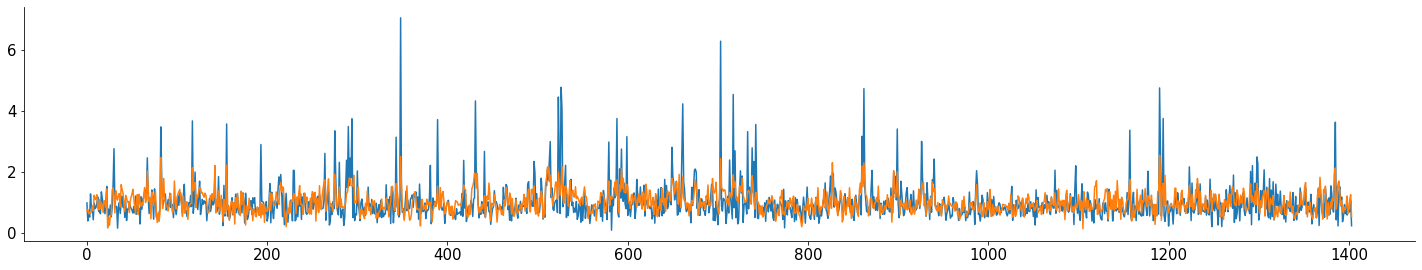

In [145]:
plt.plot(x1[1,:,0].cpu().detach().numpy())
plt.plot(test[1,:,0].cpu().detach().numpy())

In [47]:
net.rnn.weight_ih_l0.shape

torch.Size([10, 1])

In [48]:
net.rnn.weight_hh_l0.shape

torch.Size([10, 10])

In [49]:
net2 = Net(ncomp, NN1, NN2, bidi = True).to(device)

In [52]:
NN1, NN2

(1, 1)

In [50]:
net2.rnn.weight_ih_l0.shape

torch.Size([10, 1])